In [2]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

# 设置随机种子以保证结果可复现
np.random.seed(42)

# 定义数据路径
# 请确保 train_data.pkl 和 test_data.pkl 位于当前目录下的 data 文件夹中
DATA_DIR = './data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train_data.pkl')
TEST_PATH = os.path.join(DATA_DIR, 'test_data.pkl')

print("环境配置完成。")

环境配置完成。


In [4]:
def load_data(path, has_labels=True):
    """
    加载 pickle 格式的数据
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"文件未找到: {path}")
        
    with open(path, 'rb') as f:
        data = pickle.load(f)
    
    images = np.array(data['images'])
    # 将图像像素归一化到 [0, 1] 范围
    images = images / 255.0
    
    labels = None
    if has_labels:
        labels = np.array(data['labels'])
        
    return images, labels

# 加载数据
print("正在加载数据...")
# 注意：如果此处报错，请检查你的文件路径是否正确
X_train_raw, y_train = load_data(TRAIN_PATH, has_labels=True)
X_test_raw, _ = load_data(TEST_PATH, has_labels=False)

print(f"训练集形状: {X_train_raw.shape}")
print(f"训练集标签形状: {y_train.shape}")
print(f"测试集形状: {X_test_raw.shape}")

正在加载数据...
训练集形状: (1080, 28, 28, 3)
训练集标签形状: (1080, 1)
测试集形状: (400, 28, 28, 3)


显示训练集样本示例:


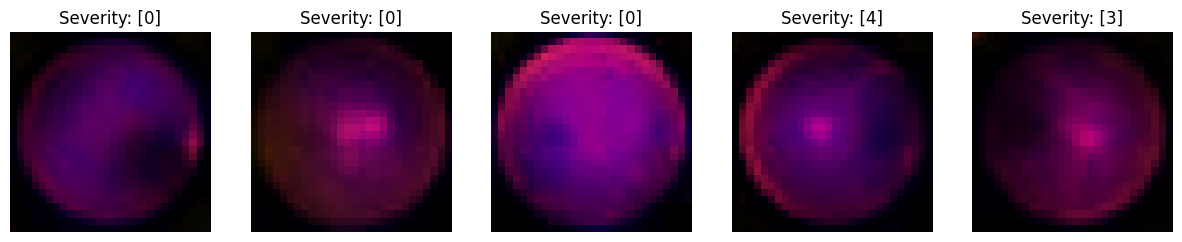

In [5]:
def show_samples(images, labels, num=5):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        # 假设图像格式为 (C, H, W)，matplotlib 需要 (H, W, C)
        img_to_show = images[i]
        if img_to_show.shape[0] == 3: 
            img_to_show = np.transpose(img_to_show, (1, 2, 0))
        
        plt.imshow(img_to_show)
        plt.title(f"Severity: {labels[i]}")
        plt.axis('off')
    plt.show()

print("显示训练集样本示例:")
show_samples(X_train_raw, y_train)

In [6]:
def create_submission(predictions, filename='submission.csv'):
    """
    生成 Kaggle 提交文件。
    IDs 必须从 1 开始索引。
    """
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID', 'Label']) # Header
        for i, label in enumerate(predictions):
            writer.writerow([i + 1, label]) # ID starts at 1
    print(f"提交文件已生成: {filename}")

In [8]:
# ==========================================
# 进阶 Milestone 1: Softmax Regression (NumPy Only)
# 目标: 击败 Strong Baseline
# ==========================================
print("--- 开始训练 Softmax Regression ---")

class SoftmaxClassifier:
    def __init__(self, input_dim, num_classes, lr=0.01, reg=1e-4):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.lr = lr
        self.reg = reg
        # 初始化权重 (D, C) 和 偏置 (C,)
        self.W = np.random.randn(input_dim, num_classes) * 0.001
        self.b = np.zeros(num_classes)

    def train(self, X, y, epochs=100, batch_size=200):
        num_train = X.shape[0]
        loss_history = []

        # One-hot 编码标签
        y_true_one_hot = np.zeros((num_train, self.num_classes))
        y_true_one_hot[np.arange(num_train), y] = 1

        print(f"开始训练: Epochs={epochs}, Batch Size={batch_size}, LR={self.lr}")

        for epoch in range(epochs):
            # 随机打乱数据
            indices = np.arange(num_train)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y_true_one_hot[indices]

            for i in range(0, num_train, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # 1. 前向传播 (Forward)
                # Scores: (N, C)
                scores = np.dot(X_batch, self.W) + self.b
                
                # Softmax: e^x / sum(e^x)
                # 数值稳定性技巧: 减去最大值防止溢出
                shifted_scores = scores - np.max(scores, axis=1, keepdims=True)
                exp_scores = np.exp(shifted_scores)
                probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

                # 2. 计算梯度 (Backprop)
                # dL/dScores = Probabilities - True_Labels
                dscores = probs - y_batch
                
                # dW = X^T * dscores
                dW = np.dot(X_batch.T, dscores)
                # db = sum(dscores)
                db = np.sum(dscores, axis=0)

                # 正则化梯度 (L2 Regularization)
                dW += 2 * self.reg * self.W

                # 平均梯度
                dW /= batch_size
                db /= batch_size

                # 3. 更新权重
                self.W -= self.lr * dW
                self.b -= self.lr * db
            
            # 每个 epoch 结束后打印一次 loss (为了速度，只计算最后一个 batch 的 loss)
            if (epoch + 1) % 10 == 0:
                # 计算 Cross-Entropy Loss
                # -sum(y_true * log(probs))
                correct_logprobs = -np.log(probs[range(len(y_batch)), np.argmax(y_batch, axis=1)] + 1e-7)
                loss = np.sum(correct_logprobs) / batch_size
                loss += self.reg * np.sum(self.W * self.W) # 加上正则项 Loss
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        scores = np.dot(X, self.W) + self.b
        return np.argmax(scores, axis=1)

# --- 关键步骤: 数据预处理 (Preprocessing) ---
# 线性模型对数据的尺度非常敏感，必须进行标准化 (Standardization)
# 公式: (X - mean) / std

print("正在进行数据标准化...")
# 计算训练集的均值和标准差
mean_image = np.mean(X_train_raw, axis=0)
std_image = np.std(X_train_raw, axis=0) + 1e-7 # 加小数值防止除以0

# 定义标准化函数
def preprocess(X):
    # 1. 展平 (Flatten)
    X_flat = X.reshape(X.shape[0], -1)
    # 2. 标准化 (Standardize) - 注意：要用训练集的 mean/std
    # 这里我们简化处理，先展平再减均值
    # 注意：为了节省内存和计算，这里我们在 Flatten 后的维度操作，或者直接在原图减完再 Flatten
    return (X - mean_image).reshape(X.shape[0], -1) / (std_image.reshape(1, -1).mean() + 1e-7) 
    # 注: 上面这种简单的除以整体 std 也是一种常见的简化版 scaling，也可以尝试逐像素标准化

# 更严谨的标准化（逐特征）：
X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test_flat = X_test_raw.reshape(X_test_raw.shape[0], -1)

# 计算 Flatten 后的均值和方差
mean_vec = np.mean(X_train_flat, axis=0)
std_vec = np.std(X_train_flat, axis=0) + 1e-8

X_train_norm = (X_train_flat - mean_vec) / std_vec
X_test_norm = (X_test_flat - mean_vec) / std_vec

print("数据标准化完成。")

# --- 训练模型 ---
input_dim = X_train_norm.shape[1]
num_classes = 5 # 假设有5类 (0,1,2,3,4)

# 可以在这里调整学习率 lr 和正则化 reg
model = SoftmaxClassifier(input_dim, num_classes, lr=0.1, reg=0.001)

# 使用全部训练数据训练
model.train(X_train_norm, y_train, epochs=200, batch_size=128)

# --- 预测与提交 ---
print("正在预测测试集...")
final_preds = model.predict(X_test_norm)

# 使用之前的函数生成 CSV
create_submission(final_preds, 'submission_softmax_baseline.csv')

--- 开始训练 Softmax Regression ---
正在进行数据标准化...
数据标准化完成。
开始训练: Epochs=200, Batch Size=128, LR=0.1
Epoch 10/200, Loss: 3.0110
Epoch 20/200, Loss: 5.1226
Epoch 30/200, Loss: 4.7813
Epoch 40/200, Loss: 2.8799
Epoch 50/200, Loss: 3.5257
Epoch 60/200, Loss: 4.2691
Epoch 70/200, Loss: 3.3520
Epoch 80/200, Loss: 4.5906
Epoch 90/200, Loss: 4.8763
Epoch 100/200, Loss: 3.6060
Epoch 110/200, Loss: 4.1761
Epoch 120/200, Loss: 4.5722
Epoch 130/200, Loss: 3.0801
Epoch 140/200, Loss: 4.5804
Epoch 150/200, Loss: 3.8772
Epoch 160/200, Loss: 4.2452
Epoch 170/200, Loss: 3.9209
Epoch 180/200, Loss: 2.6174
Epoch 190/200, Loss: 4.9323
Epoch 200/200, Loss: 3.1462
正在预测测试集...
提交文件已生成: submission_softmax_baseline.csv


In [ ]:
# ==========================================
# 里程碑 2: 使用 PyTorch 构建 CNN
# ==========================================
print("\n--- 开始里程碑 2 (Deep Learning) ---")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 检测设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 定义 Dataset
class RetinaDataset(Dataset):
    def __init__(self, images, labels=None):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        # 确保通道顺序为 (C, H, W)
        if img.shape[-1] == 3: 
            img = np.transpose(img, (2, 0, 1))
        
        img_tensor = torch.tensor(img, dtype=torch.float32)
        
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return img_tensor, label
        else:
            return img_tensor

# 划分训练集和验证集 (80% 训练, 20% 验证)
split = int(0.8 * len(X_train_raw))
X_tr, X_val = X_train_raw[:split], X_train_raw[split:]
y_tr, y_val = y_train[:split], y_train[split:]

batch_size = 32
train_loader = DataLoader(RetinaDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(RetinaDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(RetinaDataset(X_test_raw), batch_size=batch_size, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 尺寸减半
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 尺寸再减半
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 尺寸再减半
        )
        
        # 动态计算全连接层输入维度
        # 假设输入图片尺寸相同，取第一张图计算
        sample_img = torch.zeros(1, 3, X_train_raw.shape[2], X_train_raw.shape[3])
        sample_out = self.features(sample_img)
        self.flatten_dim = sample_out.numel()
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练循环
epochs = 15
print(f"开始训练 {epochs} 个 epochs...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # 验证
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f"Epoch {epoch+1}: Loss = {running_loss/len(train_loader):.4f}, Val Acc = {100 * correct / total:.2f}%")